In [1]:
import pandas as pd
import numpy as np
import random
import math
import preprocessor as p
from nltk.corpus import stopwords
import nltk
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
import string
import spacy
import es_core_news_sm
import re
from pprint import pprint

In [2]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [3]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [50]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Import Data

In [6]:
from import_data import read_data

In [7]:
data = read_data('../data', 2016, 2016, 1)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/Users/lthomas/Dropbox/galvanize/Capstone/notebooks/import_data.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data1_cleaned["tweet_time"] = pd.to_datetime(data1_cleaned["tweet_time"])
/Users/lthomas/Dropbox/galvanize/Capstone/notebooks/import_data.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data1_cleane

## Filter Out RTs

In [8]:
unique_data = data[data.is_retweet == False]

## Create Quarterly Datasets (optional)

In [ ]:
# running analysis on all 2016 data

## Group by UserID

In [9]:
def create_user_docs(tweets_vec):
    return " ".join([tweet for tweet in tweets_vec ])

In [10]:
docs = unique_data.groupby('userid')

In [11]:
df_tweets = docs['tweet_text'].apply(create_user_docs)

### Filter out users with tweets less than 10 words

In [12]:
tweet_len = pd.Series(df_tweets).apply(lambda x:  len(x.split()))

In [13]:
df_tweets = df_tweets[ tweet_len > 10 ]

In [14]:
data_list = df_tweets.values.tolist()
print(data_list[0])

Una cadena es tan fuerte como su eslabón más frágil. El peor error que alguien puede cometer es creerle a un político. Que beta, yo pensé que estábamos comenzando el mes de Julio. Sueño ven a mi. Khe https://t.co/5G6GnCo7Mt Buen día a todos los que leen esto. El que no está no hace falta. Cuando tenga otros perros los llamaría 'Delta' y 'Tomahowk'. Feliz cumpleaños mi amorsote💜💜 @HeeyDane Voy con calma y sin apuro porque no me gusta estar gastando pólvora en zamuros. El que no tiene argumento insulta y responde con preguntas. Este país necesita personas profesionales, no solo a nivel laboral sino a nivel personal. En este momento desearía estar en la orilla de la playa con unas cervezas. Todo lo que hagas importa. Nacidos para correr bebe. Todos los sábados de mi vida: https://t.co/ZkkMA3VtxT Kriss Kyle😍😍😍 https://t.co/TrvOk0PbF4 Que no duren momentos duros. El gallo no pone. https://t.co/BOl4EjbrXG Lo peligroso de un perdedor es que no tiene nada que perder. “Mas que su sonrisa, anali

## Text Preprocessing Pipeline

### Define functions for processing

In [15]:
def remove_url_emojis(tweets):
    '''
    input: tweets is a list of strings (untokenized)
    output: list of strings (untokenized)
    '''
    p.set_options(p.OPT.EMOJI, p.OPT.URL, p.OPT.RESERVED, p.OPT.NUMBER)
    
    return [ p.clean(tweet) for tweet in tweets ]

In [16]:
def tweet_to_tokens(tweets):
    return [ [token.lower() for token in tweet.split()
                 if (len(token) >= 3) and (len(token) <= 15)] for tweet in tweets]

In [17]:
def remove_symbols(tweets):
    '''
    input: tweets is a list of list of tokens
    output: list of list of tokens
    '''
    symbol_set = set('!"$%&\'()*,-./:;<>?[\\]^_`{|}~¿… °¡')
    
    return [[''.join(char for char in token if char not in symbol_set) 
              for token in tweet] 
                for tweet in tweets]

In [19]:
def remove_accents(tweets):
    def accent_check(char):
        accents = set('áéíóñ')
        if char not in accents:
            return char
        elif char == 'á':
            return 'a'
        elif char == 'é':
            return 'e'
        elif char == 'í':
            return 'i'
        elif char == 'ó':
            return 'o'
        elif char == 'ú':
            return 'u'
        elif char == 'ñ':
            return 'n'
    
    return [[ ''.join(accent_check(char) for char in token) 
                for token in tweet]
                    for tweet in tweets]

In [20]:
def remove_stopwords(tweets):
    '''
    input: tweets is a list of list of tokens
    output: list of list of cleaner tokens
    '''

    # NLTK Stop words
    stop_words_es = stopwords.words('spanish')
    stop_words_en = stopwords.words('english')
    stop_words = stop_words_es + stop_words_en
    stop_words.extend(['lol', 'LOL', 'Lol', 'LoL', 'jaja', 'jajaj'])

    return [[token for token in tweet 
                     if token not in stop_words] 
                        for tweet in tweets]

In [21]:
# def remove_laughing(tweets):
#     # remove laughter
#     matcher = re.compile(r'(ja)\1*')
#     return [[token for token in tweet
#                     if token not in [match.group() for match in matcher.finditer(' '.join(tweet))]]
#                         for tweet in tweets]

In [22]:
def make_bigrams(tweets):
    return [bigram_mod[tweet] for tweet in tweets]

In [23]:
def make_trigrams(tweets):
    return [trigram_mod[bigram_mod[tweet]] for tweet in tweets]

In [24]:
def lemmatization(tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # Lemmatize and rejoin
    
    #nlp = es_core_news_sm.load()
    tweets_out = []
    for tweet in tweets:
        doc = nlp(" ".join(tweet)) 
        tweets_out.append([token.lemma_ for token in doc 
                           if token.pos_ in allowed_postags])
    return tweets_out

### Remove URLS and Emojis

In [25]:
data_no_entities = remove_url_emojis(data_list)

### Tokenize tweets

In [26]:
data_tokens = tweet_to_tokens(data_no_entities)

In [27]:
data_tokens[0]

['una',
 'cadena',
 'tan',
 'fuerte',
 'como',
 'eslabón',
 'más',
 'frágil.',
 'peor',
 'error',
 'que',
 'alguien',
 'puede',
 'cometer',
 'creerle',
 'político.',
 'que',
 'beta,',
 'pensé',
 'que',
 'estábamos',
 'comenzando',
 'mes',
 'julio.',
 'sueño',
 'ven',
 'mi.',
 'khe',
 'buen',
 'día',
 'todos',
 'los',
 'que',
 'leen',
 'esto.',
 'que',
 'está',
 'hace',
 'falta.',
 'cuando',
 'tenga',
 'otros',
 'perros',
 'los',
 'llamaría',
 "'delta'",
 "'tomahowk'.",
 'feliz',
 'cumpleaños',
 'amorsote',
 '@heeydane',
 'voy',
 'con',
 'calma',
 'sin',
 'apuro',
 'porque',
 'gusta',
 'estar',
 'gastando',
 'pólvora',
 'zamuros.',
 'que',
 'tiene',
 'argumento',
 'insulta',
 'responde',
 'con',
 'preguntas.',
 'este',
 'país',
 'necesita',
 'personas',
 'profesionales,',
 'solo',
 'nivel',
 'laboral',
 'sino',
 'nivel',
 'personal.',
 'este',
 'momento',
 'desearía',
 'estar',
 'orilla',
 'playa',
 'con',
 'unas',
 'cervezas.',
 'todo',
 'que',
 'hagas',
 'importa.',
 'nacidos',
 'para

### Remove symbols

In [28]:
data_nosymbols = remove_symbols(data_tokens)

In [29]:
data_nosymbols[0]

['una',
 'cadena',
 'tan',
 'fuerte',
 'como',
 'eslabón',
 'más',
 'frágil',
 'peor',
 'error',
 'que',
 'alguien',
 'puede',
 'cometer',
 'creerle',
 'político',
 'que',
 'beta',
 'pensé',
 'que',
 'estábamos',
 'comenzando',
 'mes',
 'julio',
 'sueño',
 'ven',
 'mi',
 'khe',
 'buen',
 'día',
 'todos',
 'los',
 'que',
 'leen',
 'esto',
 'que',
 'está',
 'hace',
 'falta',
 'cuando',
 'tenga',
 'otros',
 'perros',
 'los',
 'llamaría',
 'delta',
 'tomahowk',
 'feliz',
 'cumpleaños',
 'amorsote',
 '@heeydane',
 'voy',
 'con',
 'calma',
 'sin',
 'apuro',
 'porque',
 'gusta',
 'estar',
 'gastando',
 'pólvora',
 'zamuros',
 'que',
 'tiene',
 'argumento',
 'insulta',
 'responde',
 'con',
 'preguntas',
 'este',
 'país',
 'necesita',
 'personas',
 'profesionales',
 'solo',
 'nivel',
 'laboral',
 'sino',
 'nivel',
 'personal',
 'este',
 'momento',
 'desearía',
 'estar',
 'orilla',
 'playa',
 'con',
 'unas',
 'cervezas',
 'todo',
 'que',
 'hagas',
 'importa',
 'nacidos',
 'para',
 'correr',
 'be

### Remove accents

In [30]:
data_noaccents = remove_accents(data_nosymbols)

In [44]:
data_noaccents[0]

['una',
 'cadena',
 'tan',
 'fuerte',
 'como',
 'eslabon',
 'mas',
 'fragil',
 'peor',
 'error',
 'que',
 'alguien',
 'puede',
 'cometer',
 'creerle',
 'politico',
 'que',
 'beta',
 'pense',
 'que',
 'estabamos',
 'comenzando',
 'mes',
 'julio',
 'sueno',
 'ven',
 'mi',
 'khe',
 'buen',
 'dia',
 'todos',
 'los',
 'que',
 'leen',
 'esto',
 'que',
 'esta',
 'hace',
 'falta',
 'cuando',
 'tenga',
 'otros',
 'perros',
 'los',
 'llamaria',
 'delta',
 'tomahowk',
 'feliz',
 'cumpleanos',
 'amorsote',
 '@heeydane',
 'voy',
 'con',
 'calma',
 'sin',
 'apuro',
 'porque',
 'gusta',
 'estar',
 'gastando',
 'polvora',
 'zamuros',
 'que',
 'tiene',
 'argumento',
 'insulta',
 'responde',
 'con',
 'preguntas',
 'este',
 'pais',
 'necesita',
 'personas',
 'profesionales',
 'solo',
 'nivel',
 'laboral',
 'sino',
 'nivel',
 'personal',
 'este',
 'momento',
 'desearia',
 'estar',
 'orilla',
 'playa',
 'con',
 'unas',
 'cervezas',
 'todo',
 'que',
 'hagas',
 'importa',
 'nacidos',
 'para',
 'correr',
 'be

### Remove laughing

In [50]:
# data_nolaughs = remove_laughing(data_noaccents) 
# need to make more efficient!

In [31]:
data_words = data_noaccents

### Create Bigram/Trigram Models

In [32]:
# Create Bigram & Trigram Models

# Build the bigram and trigram models - higher threshold fewer phrases.
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### Remove stopwords (english and spanish)

In [33]:
data_words_nostops = remove_stopwords(data_words)

### Form Bigrams

In [34]:
data_words_bigrams = make_bigrams(data_words_nostops)

### Perform lemmatization

In [35]:
nlp = spacy.load('es', disable=['parser', 'ner'], max_length = 30000000)
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [36]:
data_lemmatized[25]

['lanzar',
 'victoria',
 'portar',
 'hombre',
 'coraje',
 'defender',
 'patrio',
 'pesadilla',
 'honor_lealtad',
 'dignidad',
 'valor',
 'independencia',
 'via',
 'jajajajajaj_faltaron',
 'disociar',
 'video',
 'discursar',
 'vladimir_padrino',
 'lopez',
 'reír',
 'jajaja',
 'vamoss',
 'marcar',
 'peligroso',
 'volar',
 'ramo',
 'instrumentar',
 'duenos_imperiales',
 'bajo_egida',
 'ramosallup666',
 'punto',
 'control',
 'par',
 'nacional',
 'morrocoy',
 'heredero',
 'glorias_simon',
 'bolivar',
 'difundir',
 'imagen',
 'reír',
 'jajaja',
 'felizjueves',
 'amor',
 'nacer',
 'aqui',
 'patria_singular',
 'video',
 'adiestramiento',
 'trabajar',
 'equipar',
 'soldar',
 'tanque',
 'binomio',
 'defensa',
 'integral',
 'pais',
 'hombres_mujeres',
 'fanb',
 'pecho_afuera',
 'maxima',
 'concienciar',
 'moral',
 'vosotros',
 'garantia',
 'paz',
 'idiota',
 'nunca',
 'vida',
 'portado_uniforme',
 'militar',
 'glorioso',
 'fanb',
 'miserable_ht',
 'camarada',
 'alerta_vean',
 'tweet',
 'tumbar',


### Finally remove misc characters

In [43]:
def remove_misc(tweets):
    misc_chars = set(['#','🇻','🇪','jajajajaja','”','‘','’', 'rt', 'jajaja'])
    
    return [[token for token in tweet 
                     if token not in misc_chars] 
                        for tweet in tweets]

In [44]:
data_lem_final = remove_misc(data_lemmatized)

## Create Dictionary and Corpus

In [45]:
# Create Dictionary
id2word = corpora.Dictionary(data_lem_final)

# Create Corpus
tweets = data_lem_final

# Term Document Frequency
corpus = [id2word.doc2bow(tweet) for tweet in tweets]

# View
#print(corpus[24])

## Build Preliminary Topic Model

In [46]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=50, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [47]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(8,
  '0.000*"noticiar" + 0.000*"news" + 0.000*"mundo" + 0.000*"eeuu" + '
  '0.000*"android" + 0.000*"último" + 0.000*"nuevo" + 0.000*"vzla" + '
  '0.000*"ahora" + 0.000*"venezuela"'),
 (37,
  '0.000*"noticiar" + 0.000*"mundo" + 0.000*"eeuu" + 0.000*"nuevo" + '
  '0.000*"último" + 0.000*"mas" + 0.000*"video" + 0.000*"venezuela" + '
  '0.000*"deporte" + 0.000*"ano"'),
 (6,
  '0.000*"noticiar" + 0.000*"último" + 0.000*"mundo" + 0.000*"nuevo" + '
  '0.000*"deporte" + 0.000*"venezuela" + 0.000*"mas" + 0.000*"eeuu" + '
  '0.000*"video" + 0.000*"legionfanb"'),
 (21,
  '0.000*"noticiar" + 0.000*"mundo" + 0.000*"venezuela" + 0.000*"nuevo" + '
  '0.000*"eeuu" + 0.000*"android" + 0.000*"foto" + 0.000*"video" + 0.000*"mas" '
  '+ 0.000*"latam"'),
 (2,
  '0.000*"momento" + 0.000*"noticiar" + 0.000*"news" + 0.000*"android" + '
  '0.000*"nuevo" + 0.000*"eeuu" + 0.000*"video" + 0.000*"último" + '
  '0.000*"tecnologia" + 0.000*"mas"'),
 (1,
  '0.000*"noticiar" + 0.000*"venezuela" + 0.000*"nuevo" + 0.

In [48]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lem_final, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.651624116130135

Coherence Score:  0.41545432571974544


In [51]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


TypeError: Object of type 'complex' is not JSON serializable

PreparedData(topic_coordinates=                               x                           y  topics  cluster  \
topic                                                                           
7       (0.35003329694416496+0j)   (-0.05335528820813708+0j)       1        1   
11        (0.372179346190638+0j)   (-0.11496875713684955+0j)       2        1   
43       (0.3197296734533607+0j)     (0.1701340451959621+0j)       3        1   
31      (0.36481909828859993+0j)   (-0.10144591257969268+0j)       4        1   
32       (0.3647236837868712+0j)   (-0.04932224589666278+0j)       5        1   
47      (0.38640036330686917+0j)  (-0.026556304822984374+0j)       6        1   
27       (0.3571792972881854+0j)   (-0.09837441357355356+0j)       7        1   
39      (0.31915092882837165+0j)   (-0.07050437145858914+0j)       8        1   
40       (0.1419565184827246+0j)    (0.16419429177140846+0j)       9        1   
48       (0.3406548806771683+0j)    (0.25359312540351087+0j)      10        1 

## Optimal Number of Topics

In [52]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Breadth Search

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lem_final, start=2, limit=150, step=25)

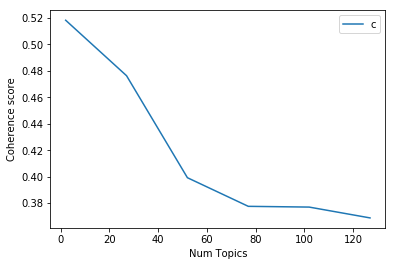

In [54]:
# Show graph
limit=150; start=2; step=25;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

### Depth Search

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lem_final, start=2, limit=50, step=5)
# Show graph
limit=50; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

### Optimal Search

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lem_final, start=2, limit=12, step=2)

# Show graph
limit=12; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

### Best LDA Model

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=###, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View Topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Model Perplexity and Coherence
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lem_final, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)